### Попробуем несколько методов прогнозирования временных рядов
В качестве данных возьмем температуру воздуха в Москве с 1998 года. Данные парсились с сайта https://www.gismeteo.ru/diary. Опробуем 2 модели - ARIMA и Prophet от META

### Подготовка данных

In [59]:
from datetime import date
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pmdarima
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from prophet import Prophet

data = pd.read_excel('C:\Study\Parser\weather.xlsx')
data.head()

,Unnamed: 0,Temperature,Day,Month,Year
0,0,-1.0,1,1,1998
1,1,-1.0,2,1,1998
2,2,-1.0,3,1,1998
3,3,1.0,4,1,1998
4,4,1.0,5,1,1998


Объеденим дату и выведем в отдельную колонку

In [60]:
data['Date'] = data.apply(lambda x: date(int(x.Year), int(x.Month), int(x.Day)), axis=1)
data = data.drop(['Unnamed: 0'], axis = 1) #также уберем лишнюю колонку

Посмотрим с каким объемом данных имеем дело

In [61]:
print(data.shape)

(9077, 5)


Проверим теперь, есть ли пропуски в данных

In [62]:
data[data.isna().any(axis=1)]

,Temperature,Day,Month,Year,Date
797,NaN,24,3,2000,2000-03-24
1755,NaN,21,11,2002,2002-11-21
1816,NaN,21,1,2003,2003-01-21
2940,NaN,24,2,2006,2006-02-24
4247,NaN,29,9,2009,2009-09-29
6419,NaN,13,9,2015,2015-09-13
6643,NaN,24,4,2016,2016-04-24
6681,NaN,1,6,2016,2016-06-01
7238,NaN,13,12,2017,2017-12-13
7371,NaN,25,4,2018,2018-04-25


Пропуски есть, устраним их, заполнив температурой за предыдущий день (для простоты)

In [63]:
id_nan = data[data.isna().any(axis=1)].index #айдишникик записей с пропусками
for id in id_nan:
    data.loc[id, 'Temperature'] = data.loc[id-1, 'Temperature']

In [64]:
data[data.isna().any(axis=1)]

,Temperature,Day,Month,Year,Date


Теперь посмотрим есть пропущенные даты

In [65]:
#в качестве индекса возьмем столбец дат
data.index = data.Date 
#проверим есть ли пропущенные даты
missing_dates = pd.date_range(start= data.index[0], end = data.index[-1]).difference(data.index)
print(missing_dates)

DatetimeIndex(['1998-05-15', '1998-05-16', '1998-05-17', '1998-05-29',
               '1998-05-30', '1998-06-06', '1999-02-04', '1999-02-05',
               '1999-02-06', '1999-02-07', '1999-02-08', '1999-02-09',
               '1999-02-10', '2000-03-21', '2000-03-22', '2000-03-23',
               '2000-07-01', '2000-07-02', '2000-07-03', '2001-08-21',
               '2001-08-22', '2001-08-23', '2001-08-24', '2001-08-25',
               '2001-08-26', '2001-08-27', '2001-08-28', '2001-08-29',
               '2001-08-30', '2001-08-31', '2003-02-11', '2003-03-21',
               '2003-06-17', '2003-06-18', '2003-06-19', '2003-06-20',
               '2007-06-22', '2007-06-23', '2007-07-11', '2007-08-18',
               '2007-08-19', '2008-08-21', '2011-06-19', '2012-02-06',
               '2012-10-27', '2017-11-15', '2017-11-26', '2017-11-27',
               '2018-09-18', '2018-09-19', '2021-07-15', '2021-10-22',
               '2021-10-23', '2022-11-08'],
              dtype='datetime64[n

Пропущенные даты действительно есть, устраним их, заполнив также значениями за предыдущий день

In [91]:
#заполним предыдущими значениями
for date_cur in missing_dates:
    date_prev = (date_cur - timedelta(days = 1)).date()
    date_cur = date_cur.date()
    data.loc[date_cur] = data.loc[date_prev]
data = data.sort_index()
data.Date = data.index

In [67]:
#проверим есть ли пропущенные даты
missing_dates = pd.date_range(start= data.index[0], end = data.index[-1]).difference(data.index)
print(missing_dates)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


От пустых записей почистили. Посмотрим теперь как выглядит график этой температуры

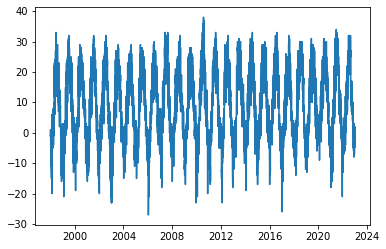

In [68]:
plt.plot(data.Temperature)

## Модели

### ARIMA
Для ARIMA периодичность в 365 дней требует слишком больших вычислений, поэтому упростим задачу - будем предсказывать среднемесячную температуру

#### Сделаем выборку ежемесячной

In [105]:
weather_resample = []
for year in range(1998, 2023):
    for month in range(1,13):
        weather_resample += [
            {
                'Temperature' : data[(data.Month == month) & 
                                     (data.Year == year)
                                    ].Temperature.mean(),
                'Year' : year,
                'Month' : month
            }
        ]

data_resample = pd.DataFrame(weather_resample)
data_resample.head()

,Temperature,Year,Month
0,-3.774194,1998,1
1,-5.642857,1998,2
2,1.419355,1998,3
3,6.866667,1998,4
4,16.161290,1998,5


In [106]:
#добавим также столбец с датами (чтобы отображать на графиках), и возьмем его в качестве индекса
data_resample['Date'] = data_resample.apply(lambda x: date(int(x.Year),
                                                           int(x.Month), int(1)), axis=1)
data_resample.set_index('Date', inplace=True)

<AxesSubplot:xlabel='Date'>

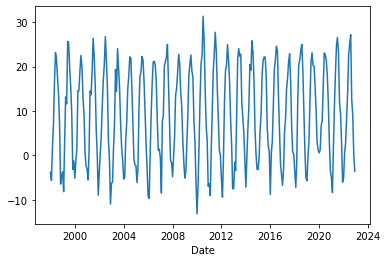

In [107]:
data_resample.Temperature.plot()

In [108]:
ts = data_resample['Temperature']

#### Подбор параметров

Пойдем простым путем - попробуем подобрать параметры автоматом с помощью пакета pmdarima. Попробуем две модели - без сезонности и с ней

In [109]:
model = pmdarima.arima.auto_arima(ts[:-12])
model_season = pmdarima.arima.auto_arima(ts[:-12], m = 12)
print(model, model_season)

 ARIMA(2,0,2)(0,0,0)[0] intercept  ARIMA(0,0,1)(1,0,2)[12] intercept


Построим результат:

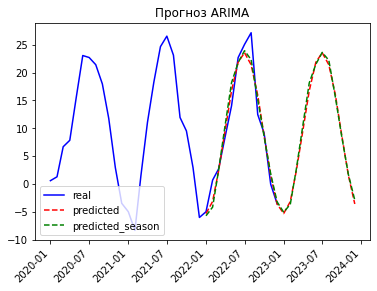

In [110]:
plt.plot(ts[-36:], c = 'b', label ='real')
plt.plot(model.predict(24), c = 'r', ls = '--', label = 'predicted')
plt.plot(model_season.predict(24), c = 'g', ls = '--', label = 'predicted_season')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Прогноз ARIMA')
plt.show()

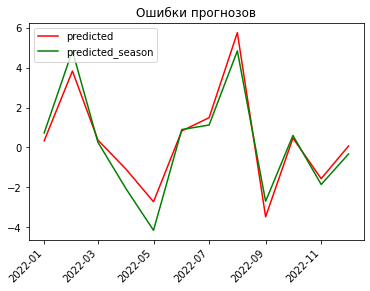

In [111]:
plt.plot(ts[-12:] - model.predict(12), c = 'r',  label = 'predicted')
plt.plot(ts[-12:] - model_season.predict(12), c = 'g',  label = 'predicted_season')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Ошибки прогнозов')
plt.show()

Визуально два прогноза получились очень близкими, попробуем оценить их среднеквадратичным отклонением

In [112]:
def rmse(a, b):
    ans = 0
    for i in a - b:
        ans += i**2
    return ans ** (0.5)

In [113]:
print("non seasonal", rmse(ts[-12:], model.predict(12)))
print("seasonal", rmse(ts[-12:], model_season.predict(12)))

non seasonal 8.627461074550176
seasonal 9.082425835452776


Без учета сезонности ошибка получилась чуть меньше

### Prophet
Попробуем какие результаты получим на фейсбуковском пакете "из коробки". Ему уже скормим ежедневный прогноз вместо среднемесячного

In [92]:
#Подготовим данные - уберем лишние колонки и переименуем нужные
predictions = 60
data_proph = data[['Temperature','Date']]
data_proph.columns = ['y','ds']
data_proph.head()

,y,ds
Date,,
1998-01-01,-1.0,1998-01-01
1998-01-02,-1.0,1998-01-02
1998-01-03,-1.0,1998-01-03
1998-01-04,1.0,1998-01-04
1998-01-05,1.0,1998-01-05


In [93]:
data_proph.shape

(9131, 2)

In [94]:
train_df = data_proph[:-predictions]  #из выборки отрежем 2 месяца значений, на которых потом оценим модель

In [95]:
train_df.tail()

,y,ds
Date,,
2022-10-28,9.0,2022-10-28
2022-10-29,10.0,2022-10-29
2022-10-30,6.0,2022-10-30
2022-10-31,2.0,2022-10-31
2022-11-01,1.0,2022-11-01


In [97]:
m = Prophet()
m.fit(train_df) #обучаем модель
future = m.make_future_dataframe(periods=365) 
forecast = m.predict(future)#строим прогноз

17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:21 - cmdstanpy - INFO - Chain [1] done processing


Взглянем на тренд и сезонные составляющие прогноза

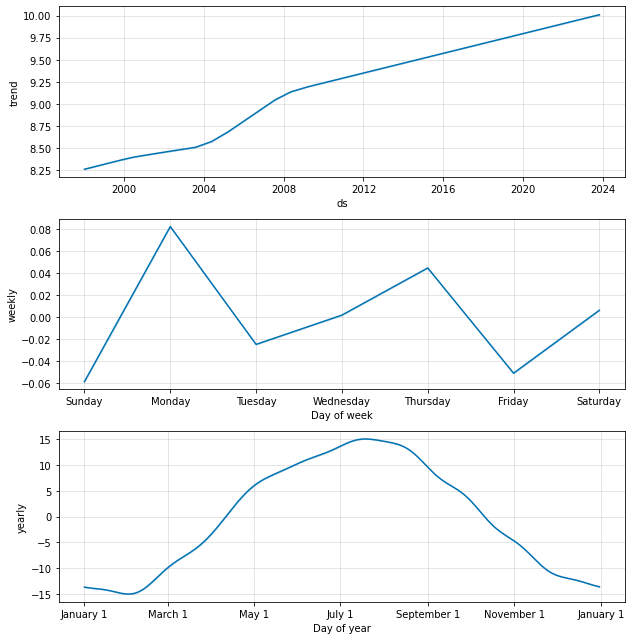

In [98]:
m.plot_components(forecast);
forecast = forecast[forecast.ds > datetime(2022,10,31)][['ds', 'yhat']]
forecast.index = forecast.ds

Посмотрим на получившийся прогноз на год

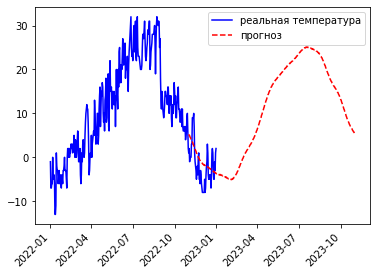

In [99]:
data_proph.index = data_proph.ds
plt.plot(data_proph.y[-365:], c = 'b', label = 'реальная температура')
plt.plot(forecast.yhat, c = 'r', ls = '--', label = 'прогноз')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

Чисто визуально, если не учитывать шум на +-5 градусов прогноз выглядит правдоподобно. Сравним теперь прогноз и реальные данные детальнее

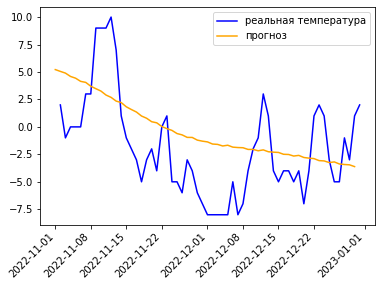

In [100]:
plt.plot(data_proph.y[-60:], c = 'b', label = 'реальная температура')
plt.plot(forecast.yhat[:60], c = 'orange', label = 'прогноз')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

In [101]:
print("prophet rmse", rmse(data_proph.y[-61:], forecast.yhat[:61]))

32.21494122418094

### Сравнение
Попробуем как-то сравнить prohpet и arima. построем прогноз prophet-ом на год, возьмем среднемесячные значения и сравним с аримой

In [114]:
ts[:-12].tail()

Date
2021-08-01    23.129032
2021-09-01    11.933333
2021-10-01     9.516129
2021-11-01     2.933333
2021-12-01    -6.032258
Name: Temperature, dtype: float64

Среднемесячные данные были до декабря. Берем до 2021-12-31

In [119]:
data_proph_compare = data_proph[data_proph.ds <= datetime(2021,12,31).date() ]

In [129]:
predictions = 365
train_df_compare = data_proph_compare
m_compare = Prophet()
m_compare.fit(train_df_compare) #обучаем модель
future = m_compare.make_future_dataframe(periods=predictions*2) 
forecast = m_compare.predict(future)#строим прогноз

17:20:13 - cmdstanpy - INFO - Chain [1] start processing
17:20:14 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
#Из прогноза выделим среднемесячную температуру
forecast.index = forecast.ds
forecast['Year'] = forecast.ds.apply(lambda x : x.year)
forecast['Month'] = forecast.ds.apply(lambda x : x.month)
prophet_resample = []
for year in range(forecast.index[0].year, forecast.index[-1].year+1):
    for month in range(1,13):
        prophet_resample += [
            {
                'Temperature' : forecast[(forecast.Month == month) & 
                                     (forecast.Year == year)
                                    ].yhat.mean(),
                'Year' : year,
                'Month' : month
            }
        ]

prophet_resample = pd.DataFrame(prophet_resample)

prophet_resample['Date'] = prophet_resample.apply(lambda x: date(int(x.Year),
                                                           int(x.Month), int(1)), axis=1)
prophet_resample.set_index('Date', inplace=True)
prophet_resample.head()

,Temperature,Year,Month
Date,,,
1998-01-01,-5.942396,1998,1
1998-02-01,-5.035909,1998,2
1998-03-01,1.317234,1998,3
1998-04-01,9.811783,1998,4
1998-05-01,16.696324,1998,5


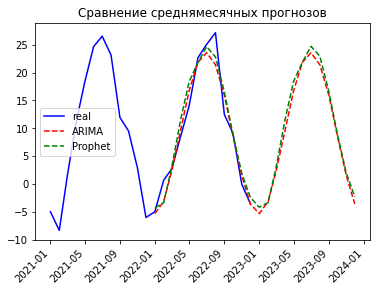

In [152]:
plt.plot(ts[-24:], c = 'b', label ='real')
plt.plot(model.predict(24), c = 'r', ls = '--', label = 'ARIMA')
plt.plot(prophet_resample.Temperature[-24:], c = 'g', ls = '--', label = 'Prophet')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Сравнение среднямесячных прогнозов')
plt.show()

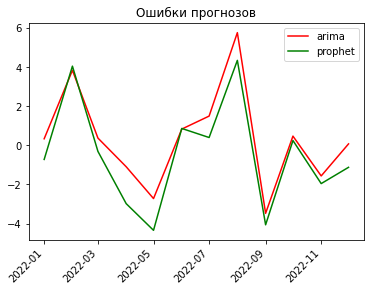

In [157]:
plt.plot(ts[-12:] - model.predict(12), c = 'r',  label = 'arima')
plt.plot(ts[-12:] - prophet_resample.Temperature[-24:-12], c = 'g',  label = 'prophet')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Ошибки прогнозов')
plt.show()

In [156]:
print("arima", rmse(ts[-12:], model.predict(12)))
print("prophet", rmse(ts[-12:], prophet_resample.Temperature[-24:-12]))

arima 8.627461074550176
prophet 9.28581556615178


ARIMA без сезонной составляющей и тут показала чуть лучший результат. 

### Выводы
Попробовали две модели (ARIMA даже в двух вариациях), увидели их ограничения (ARIMA не переваривает периоды в 365 дней, также для правильной работы моделей нужен равномерный временной ряд - соответственно нужно проверять и чистить данные)
На упрощенной задаче (ежемесячная температура) результаты у моделей получились во-первых близкие друг к другу, а во вторых близкие к реальности (по крайней мере достаточно близкие для наглядности примера) 